# Bogusz Janiak ML Project - House Prices: Advanced Regression Techniques

This notebook will show a full workflow of building a regression model for the House Prices competition at Kaggle. This contest is focusing on Feature Engineering and using advanced regression techniques. The best score I have achieved using the techniques presented in this notebook is **0.11931**, and this currently places me in the **top 5%** of all competitors.
The project has six main sections:
1. Introduction
2. Explanatory Data Analysis
3. Feature Engineering
4. Pre-Modeling Tasks
5. Modeling
6. Final prediction & submission  

If you have any questions or remarks, please contact me at montana102@gmail.com

# INTRODUCTION

In [672]:
# Importing necessary modules that will be used along the whole project pipeline.

# MAIN MODULES

import os
import datetime

# DATA ANALYSIS & CLEANING
import pandas as pd
import numpy as np
from scipy.stats import norm, skew
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# DATA VISUALIZATION

%matplotlib inline

import seaborn as sns
from matplotlib import pyplot as plt

# MODELING

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, ElasticNet, Lasso, LassoCV, BayesianRidge, SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

In [673]:
# Setting seed upfront for reproduction purposes.
SEED = 42

In [674]:
# Setting a path variable for data directory.
HAUSING_PATH = os.path.join("data")

In [675]:
# Creating a function that will load the data.
def load_hausing_data(filename, path=HAUSING_PATH):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

In [676]:
df_train = load_hausing_data("train.csv")
df_test = load_hausing_data("test.csv")

In [677]:
# taking a look at 5 sample rows from train dataset.
df_train.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
942,943,90,RL,42.0,7711,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,Oth,Abnorml,150000
1331,1332,80,RL,55.0,10780,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,132500
37,38,20,RL,74.0,8532,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,153000
134,135,20,RL,78.0,10335,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2006,WD,Normal,180000
21,22,45,RM,57.0,7449,Pave,Grvl,Reg,Bnk,AllPub,...,0,NaN,GdPrv,NaN,0,6,2007,WD,Normal,139400


In [678]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# EXPLORATORY DATA ANALYSIS

## PRELIMINARY ANALYSIS - CORRELATION

In [679]:
def draw_scatter(df, dep, indep):
    """
    Helper function that creates a scatterplot.
    """
    plt.rcdefaults()
    sns.set_context('paper')
    sns.set(style='darkgrid')
    
    data = pd.concat([df[dep], df[indep]], axis=1)
    sns.scatterplot(x=indep, y=dep, data=data)
    
def draw_boxplot(df, dep, indep):
    """
    Helper function that creates a boxplot.
    """
    data = pd.concat([df[dep], df[indep]], axis=1)
    plt.figure(figsize=(18,9), dpi=140)
    sns.boxplot(x=indep, y=dep, data=data)

In the first take, we are looking at the most promising variables, with regards to explaining SalePrice which is the target variable.  As you can see on the scatterplots below, the variables I have inspected are having a linear relationship with the SalePrice. This is not an accident, since my choice was based on methods presented in comprehensive data exploration done by Pedro Marcelino, which you can find in the link below:

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

I encourage you to check it out since it provides a very good understanding of the dataset we are working with.

Excel files I was working with during exploration can be found under *utils/hausing_features.xlsx*.

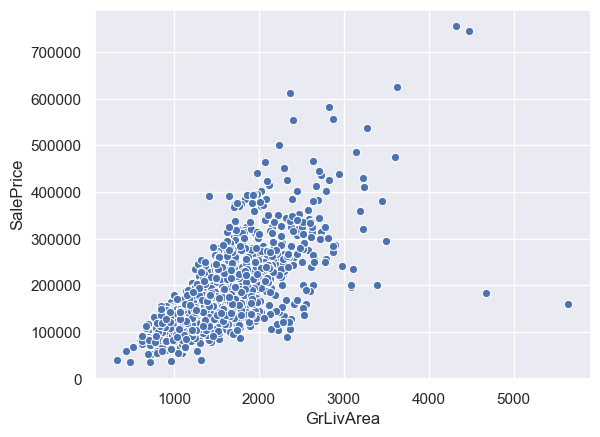

In [680]:
draw_scatter(df_train, 'SalePrice', 'GrLivArea')

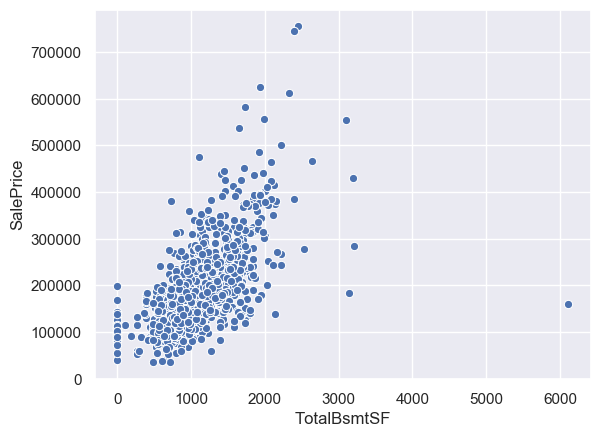

In [681]:
draw_scatter(df_train, 'SalePrice', 'TotalBsmtSF')

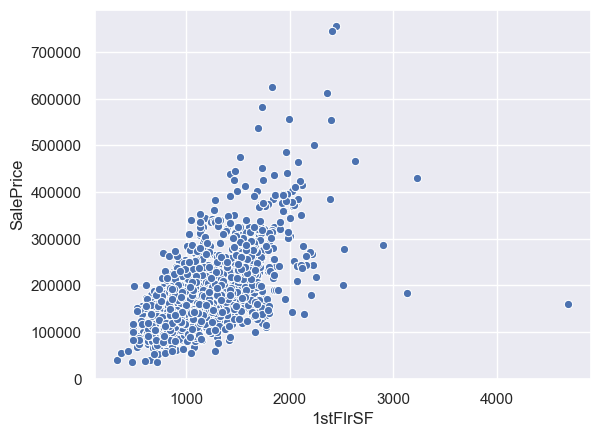

In [682]:
draw_scatter(df_train, 'SalePrice', '1stFlrSF')

We will also inspect the most promising discrete variables by drawing boxplots.

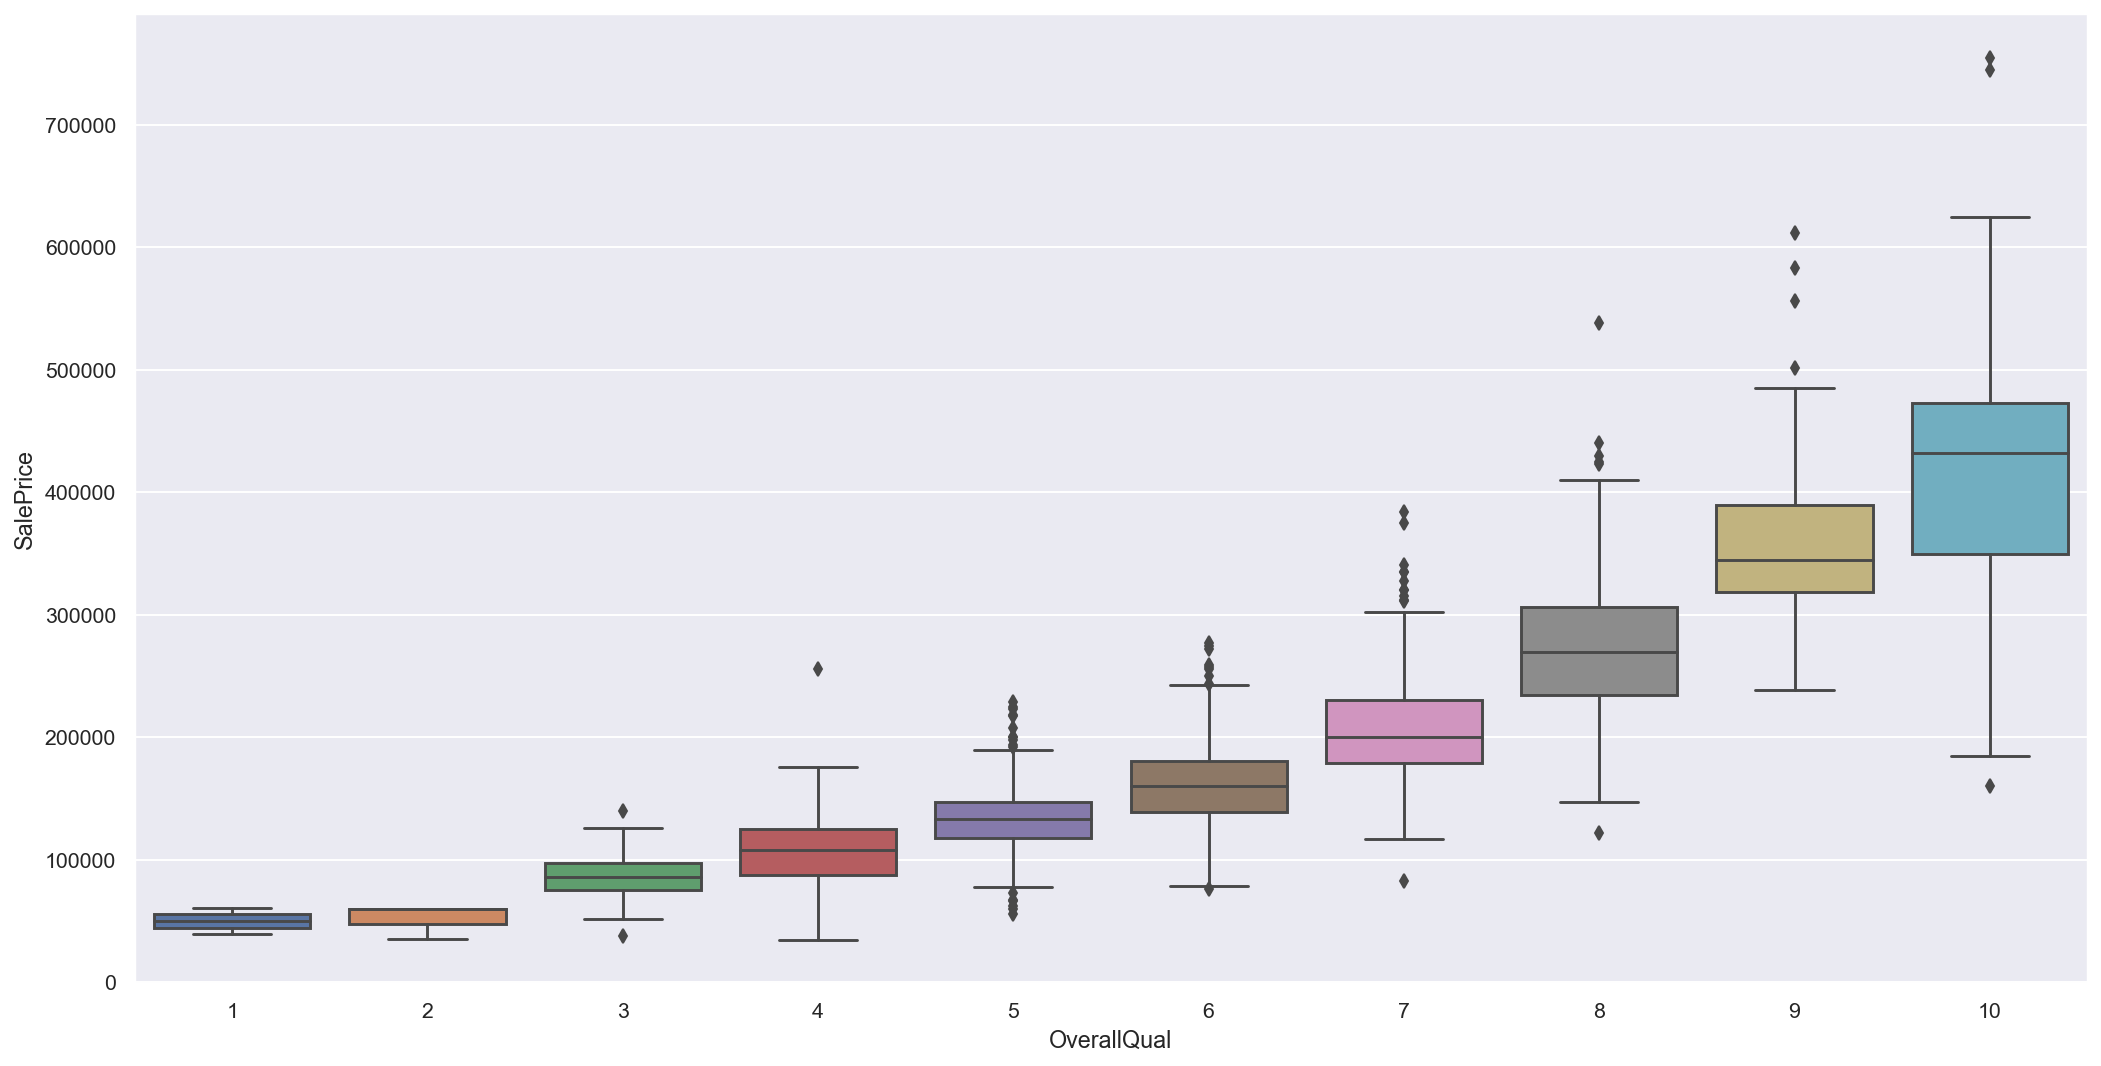

In [683]:
draw_boxplot(df_train, 'SalePrice', 'OverallQual')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

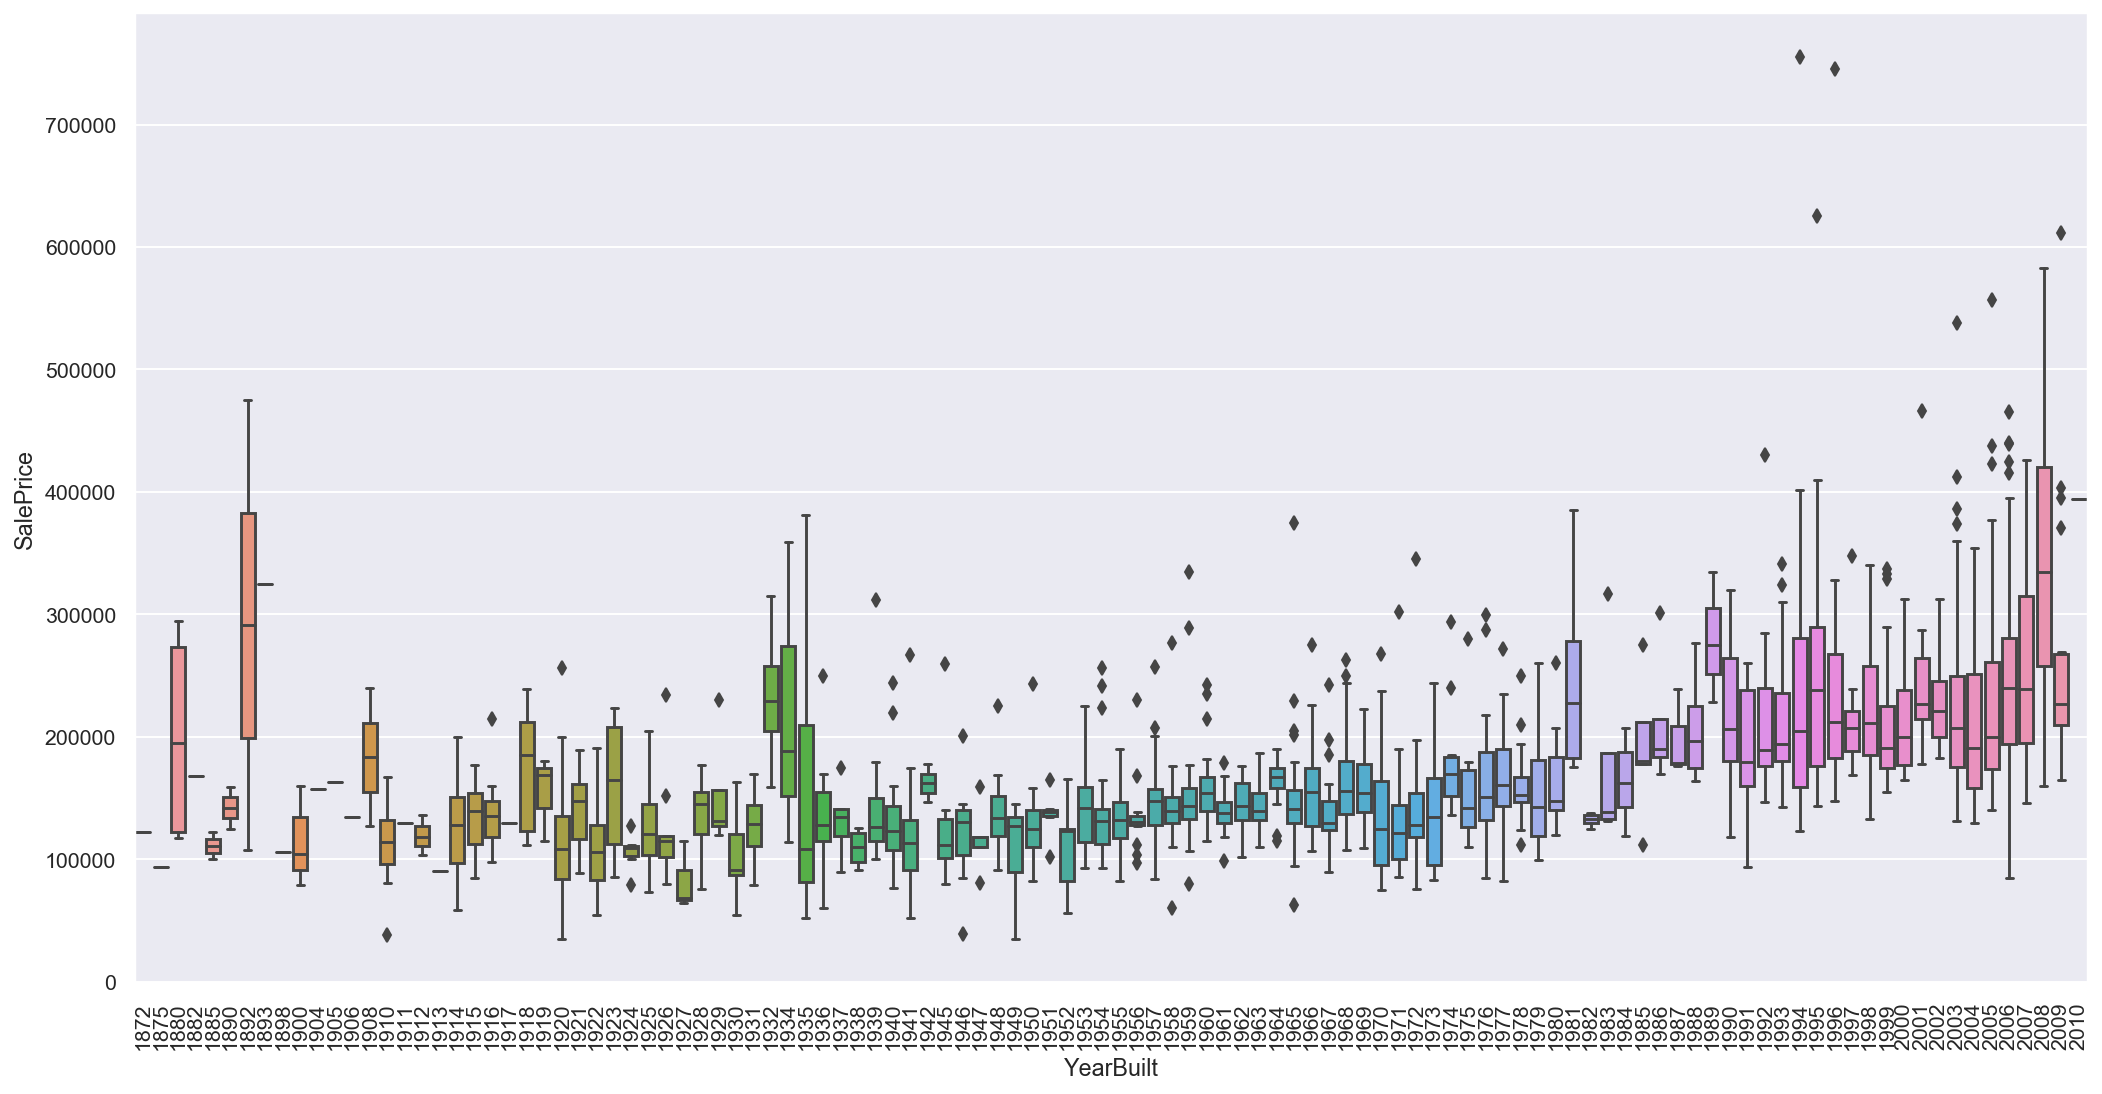

In [684]:
draw_boxplot(df_train, 'SalePrice', 'YearBuilt')
plt.xticks(rotation=90)   # rotating ticks so that they are somehow readable.

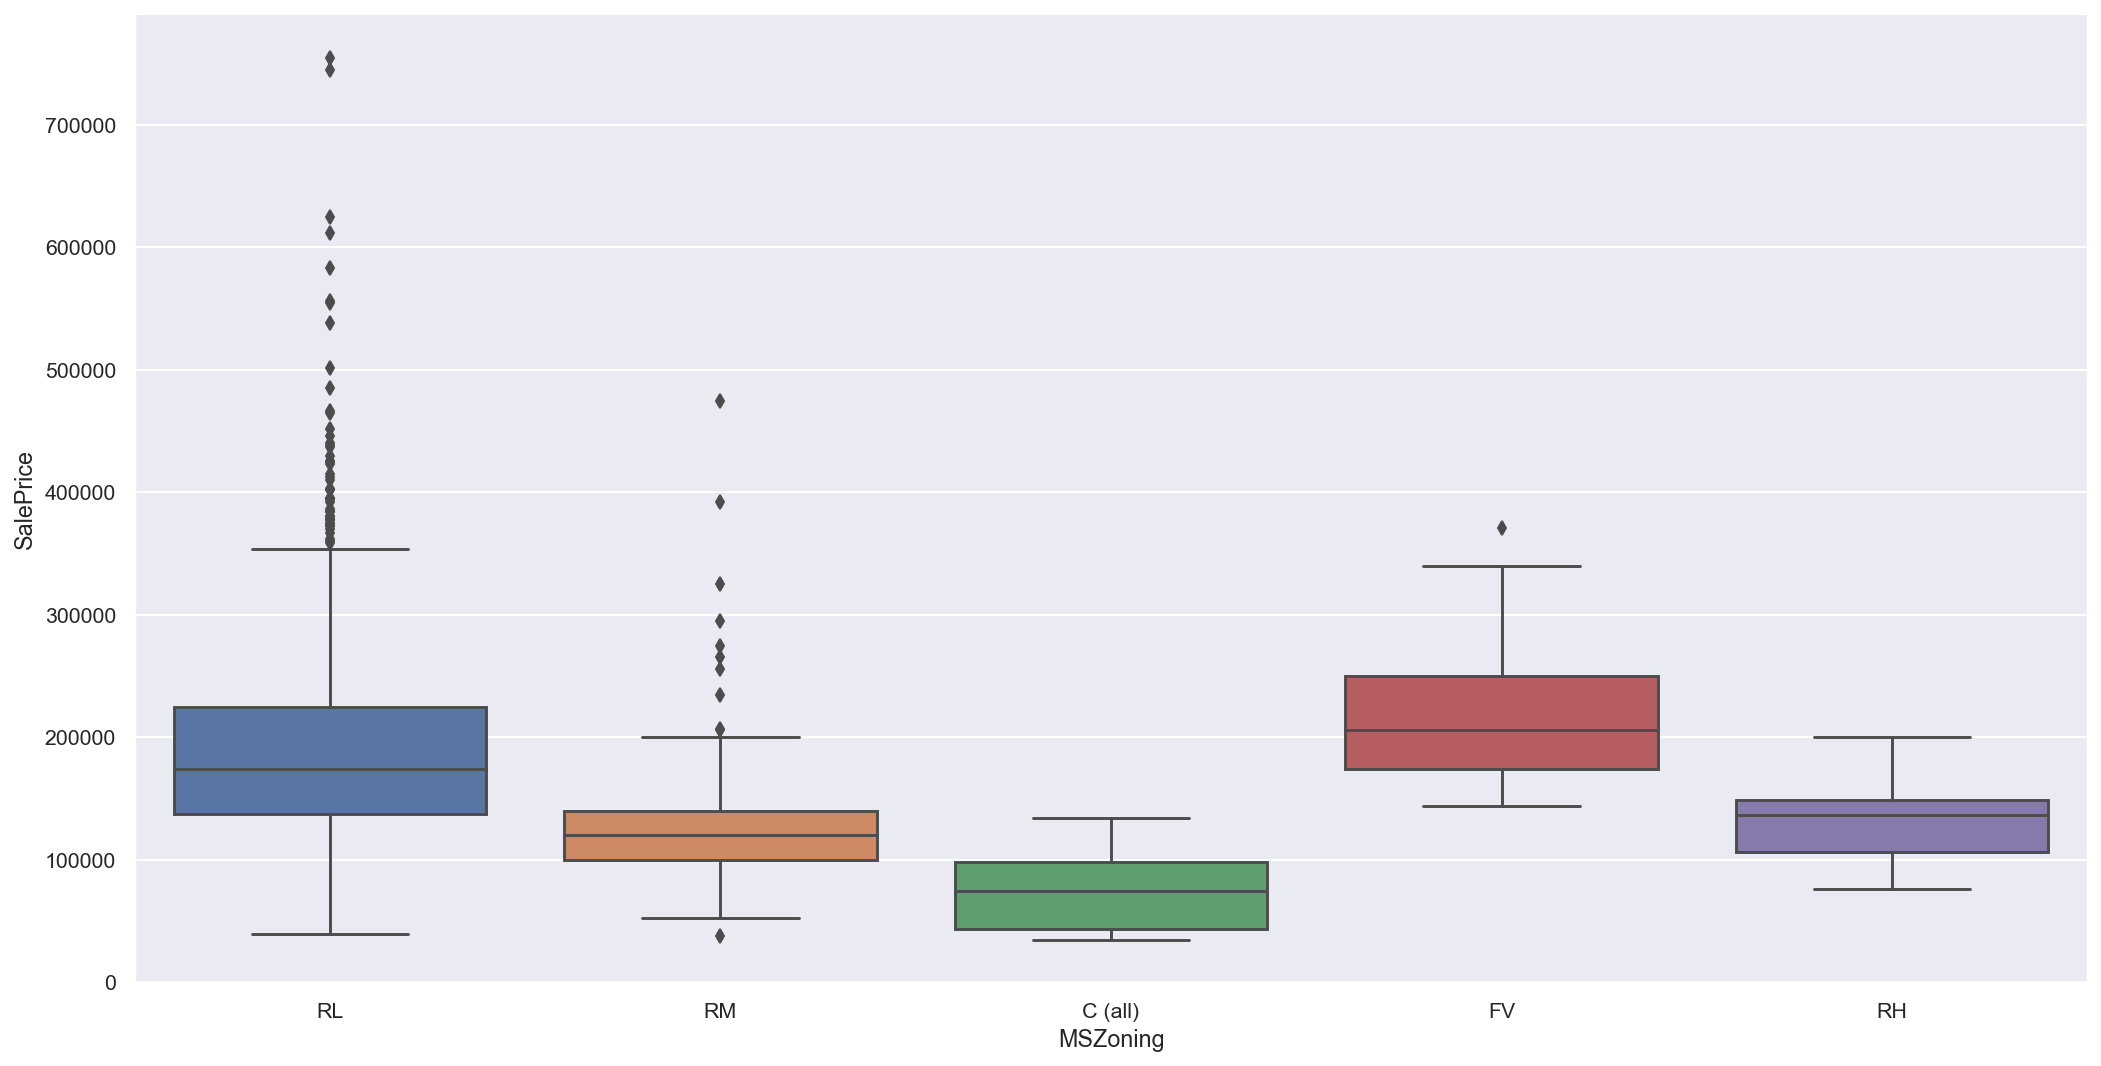

In [685]:
draw_boxplot(df_train, 'SalePrice', 'MSZoning')

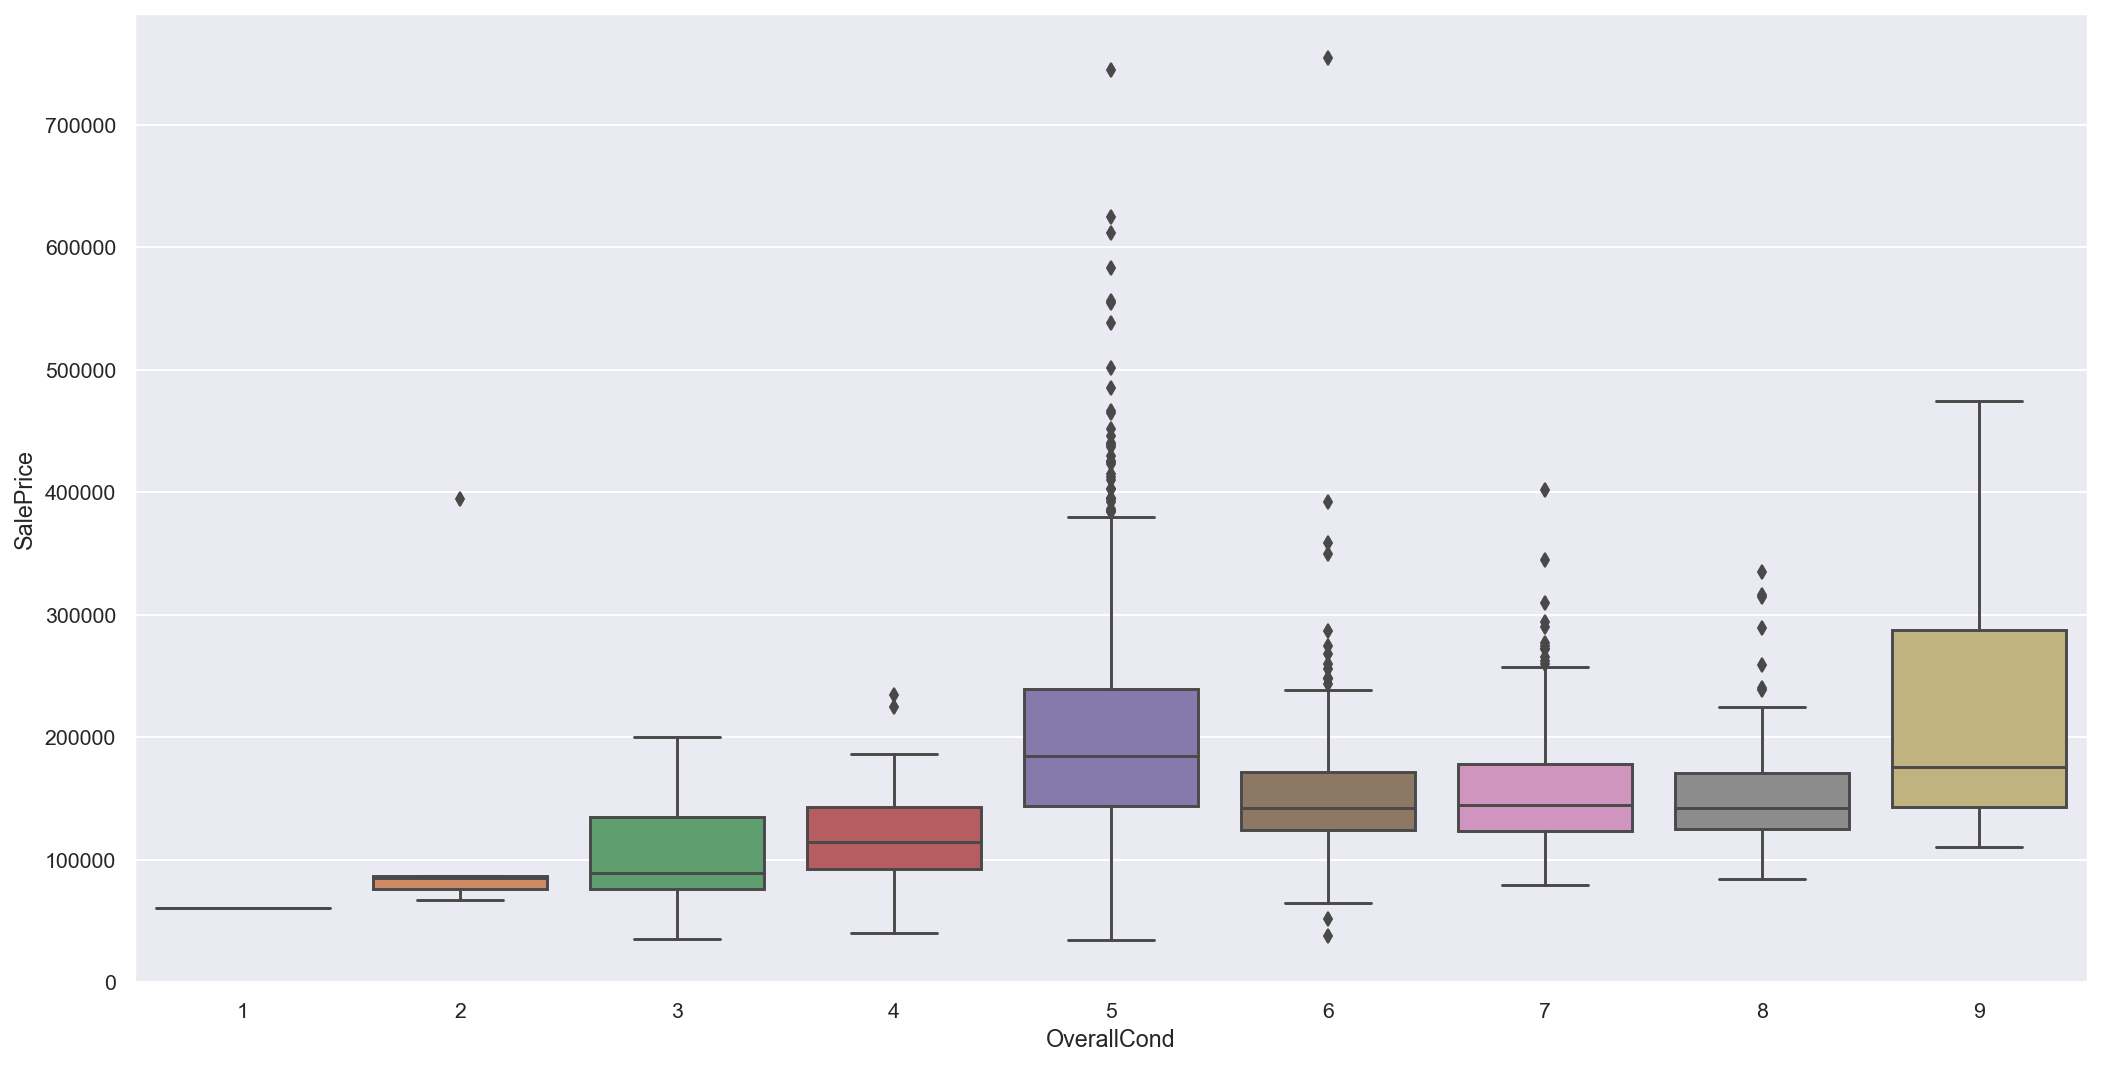

In [686]:
draw_boxplot(df_train, 'SalePrice', 'OverallCond')

Text(0.5, 1, 'Correlations Among Features')

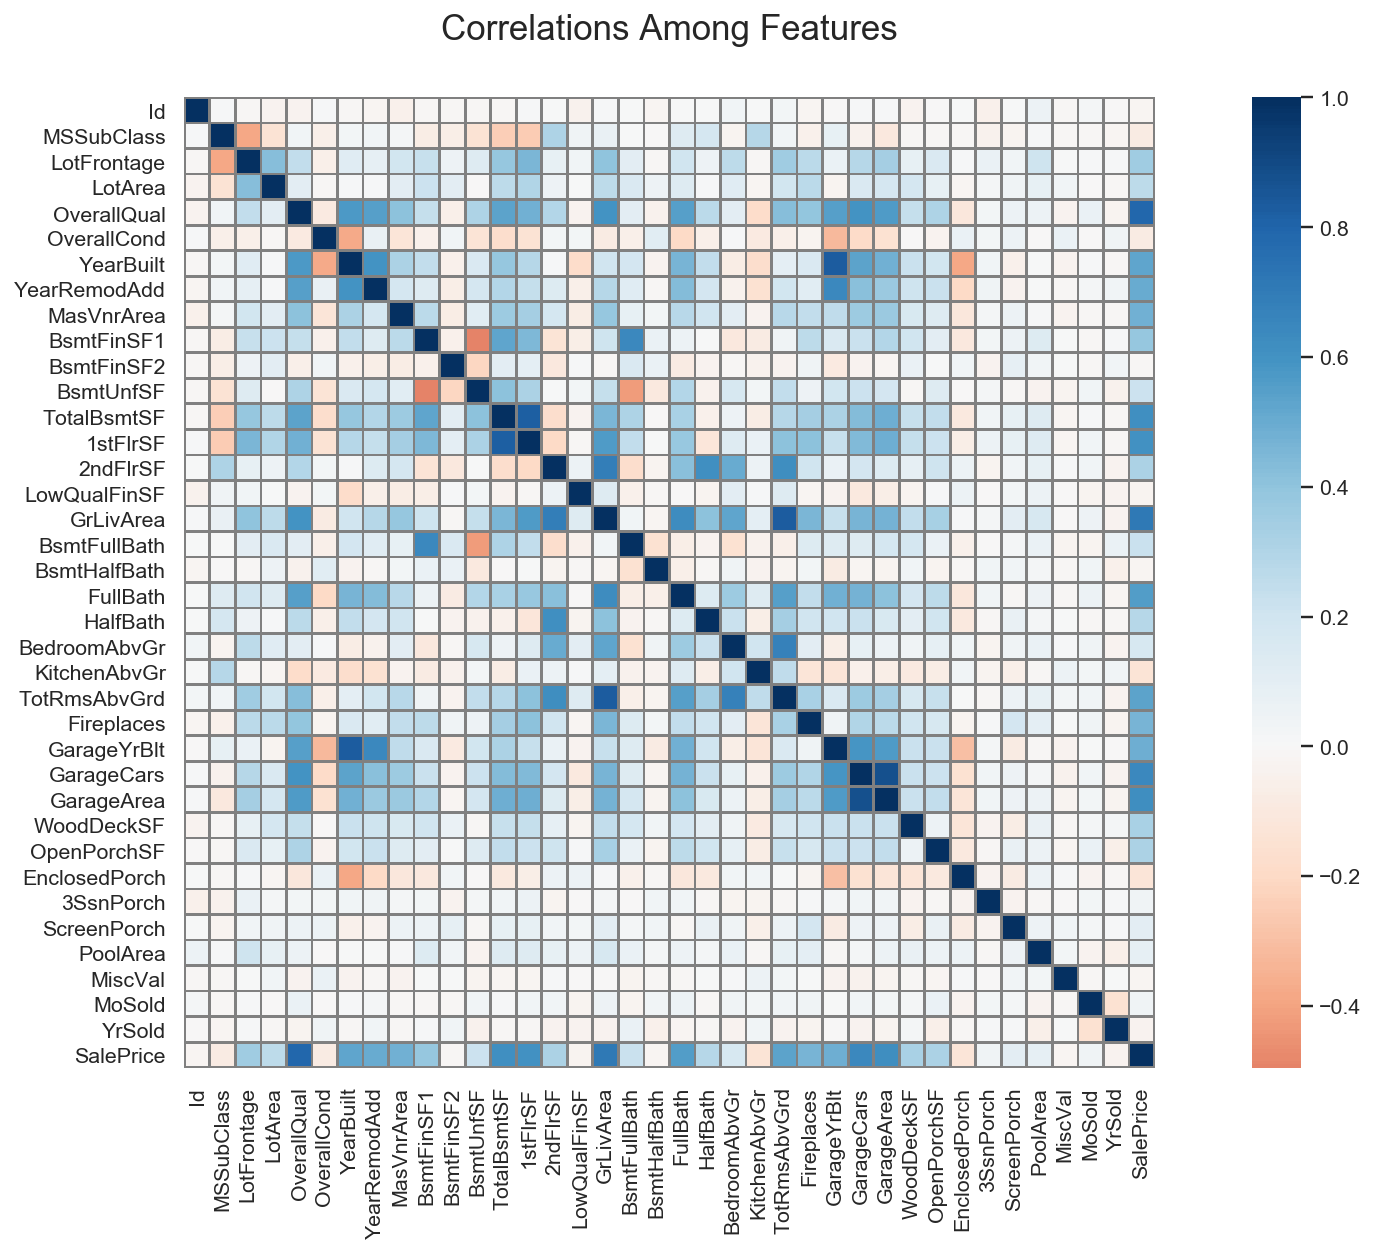

In [687]:
# Constructing a correlation matrix for all the features.
corr_matrix = df_train.corr()
plt.figure(figsize=(18,9), dpi=140)
sns.heatmap(corr_matrix, cmap='RdBu', linewidths=.9, linecolor='gray', center=0, square=True)
plt.title("Correlations Among Features", y = 1, fontsize = 18, pad = 30)

Text(0.5, 1, 'SalePirce correlation of top 10 features')

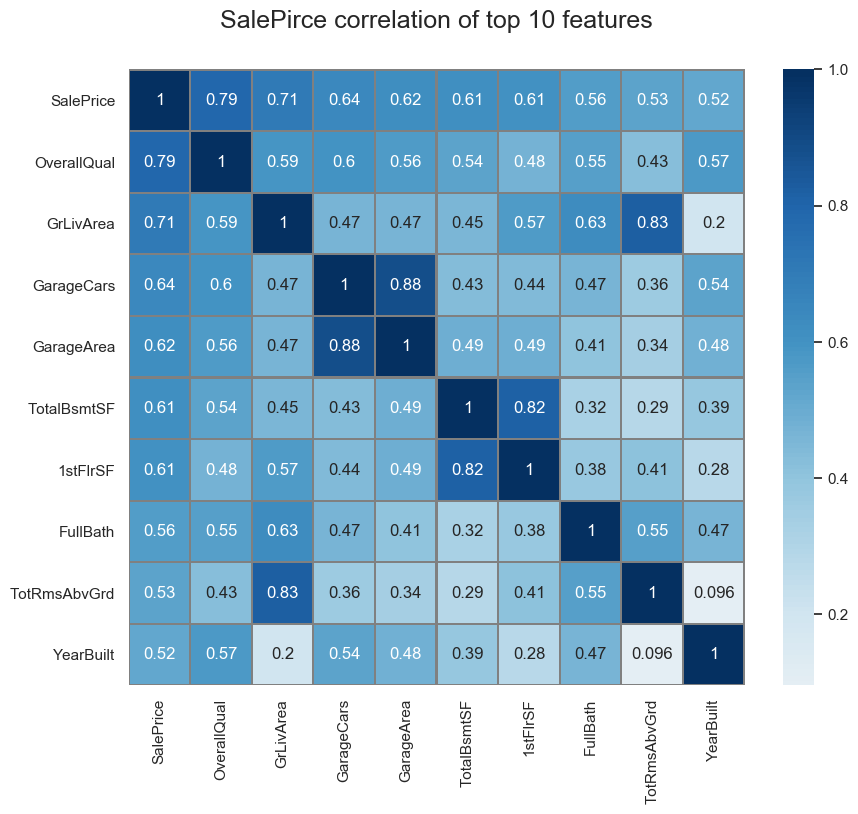

In [688]:
# Correlation matrix for the top 10 features in terms of correlation with target variable.
cols = corr_matrix.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
plt.figure(figsize=(10,8), dpi=100)
sns.heatmap(cm, cmap='RdBu', linewidths=.9, linecolor='gray', fmt='.2g', center=0, square=True, annot=True, yticklabels=cols.values, xticklabels=cols.values)
plt.title("SalePirce correlation of top 10 features", y = 1, fontsize = 18, pad = 30)

<Figure size 1000x800 with 0 Axes>

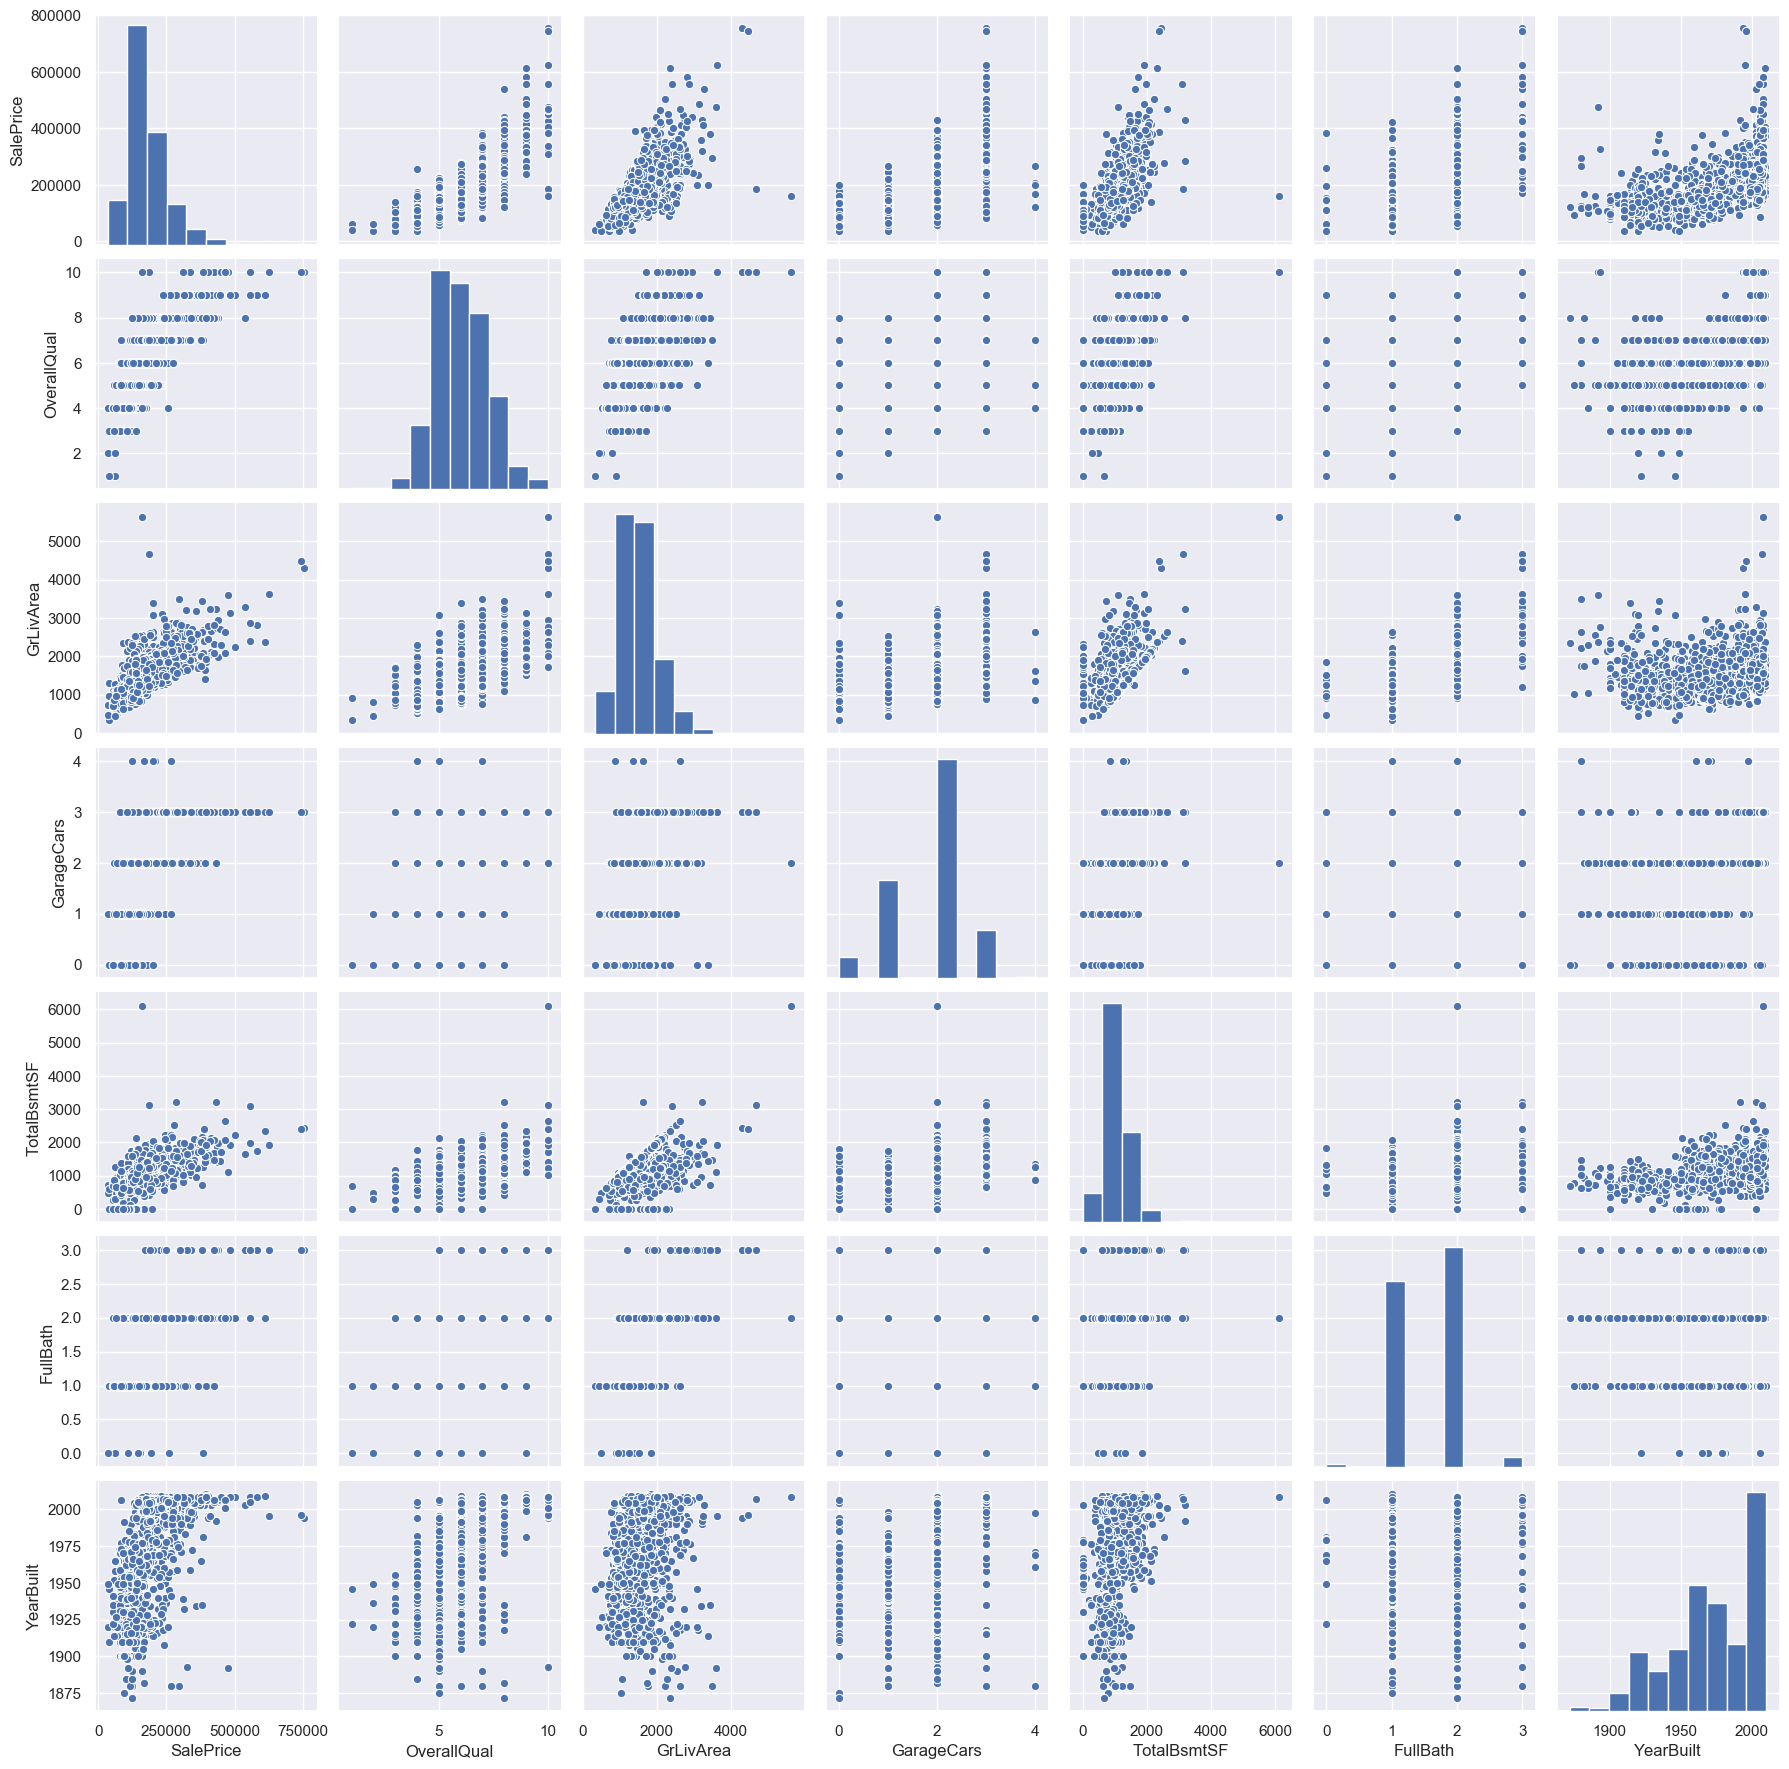

In [689]:
# Different way of looking at variables which are having strongest correlation with target variable. 
plt.figure(figsize=(10,8), dpi=100)
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols])

## OUTLIERS

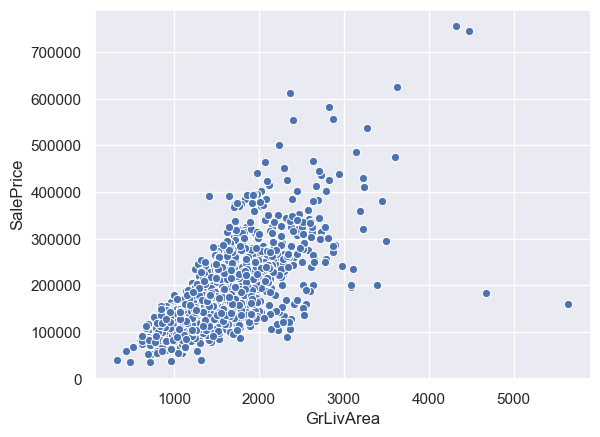

In [690]:
draw_scatter(df_train, 'SalePrice', 'GrLivArea')

We can see that two outliers do not follow the linear relationship between the data. It is always a hard decision to deliberately remove data, especially if we are working with smaller data sets, but I believe this is the way to go in this case. We can observe that these two are having by far the largest area, yet the price is suspiciously low, and it can only create confusion for our model when predicting the final values of the unseen data. 

In [691]:
# Looking at the two suspicious data points.
df_train.sort_values(by='GrLivArea', ascending=False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


In [692]:
# Removing outliers from the data set.
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

The author of the fantastic notebook linked below presented a clever way to detect outliers and he was strongly confident about their impact on overfitting (they were increasing it). I followed his logic and based on the info he provided I have removed those rows. The problem is that I can not successfully reproduce his method, which means I can not justify removing those particular rows, other than just by trial-error approach. Removing those rows indeed yielded better results for the final model I have submitted.

https://www.kaggle.com/pcbreviglieri/enhanced-house-price-predictions

You can find my attempt of reproducing his results under *utils/outliers_impact.csv*.

In [693]:
# Removing additional outliers as per info above.
df_train = df_train.drop(df_train.index[[30, 462, 588, 632, 1324]])

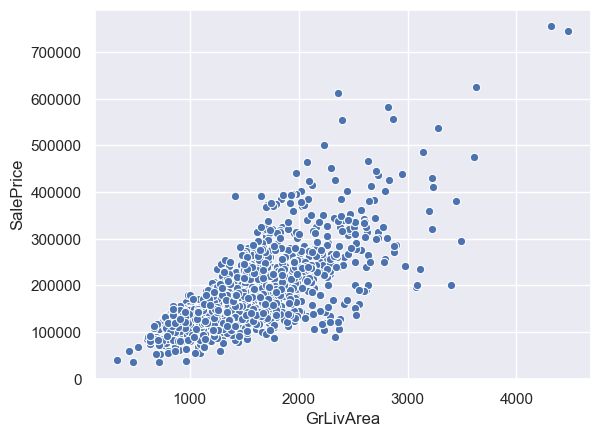

In [694]:
# Plotting it once again to see how the relationship looks after removing outliers.
draw_scatter(df_train, 'SalePrice', 'GrLivArea')

## TARGET VARIABLE

In [695]:
df_train['SalePrice'].describe()

count      1453.000000
mean     181280.050241
std       79387.130665
min       34900.000000
25%      130000.000000
50%      163500.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [696]:
def show_target_distribution(df):
    # styling
    plt.rcdefaults()
    plt.figure(figsize=(18,9), dpi=140)
    sns.set_context('paper')
    sns.set(style='darkgrid')
    
    # distribution plot
    sns.distplot(df['SalePrice'], fit=norm)
    mu, sigma = stats.norm.fit(df['SalePrice'])
    plt.legend([f'$\mu =$ {round(mu, 2)} and $\sigma =$ {round(sigma, 2)}'], loc='best')
    plt.title('Target Variable - SalePrice distribution')
    
    # probability plot
    fig = plt.figure()
    res = stats.probplot(df_train['SalePrice'], plot=plt)
    
    # skewness and kurtosis
    s = df['SalePrice'].skew()
    k = df['SalePrice'].kurt()
    print(f'Skewness: {s}')
    print(f'Kurtosis: {k}')

Skewness: 1.8915095560207282
Kurtosis: 6.560727400242169


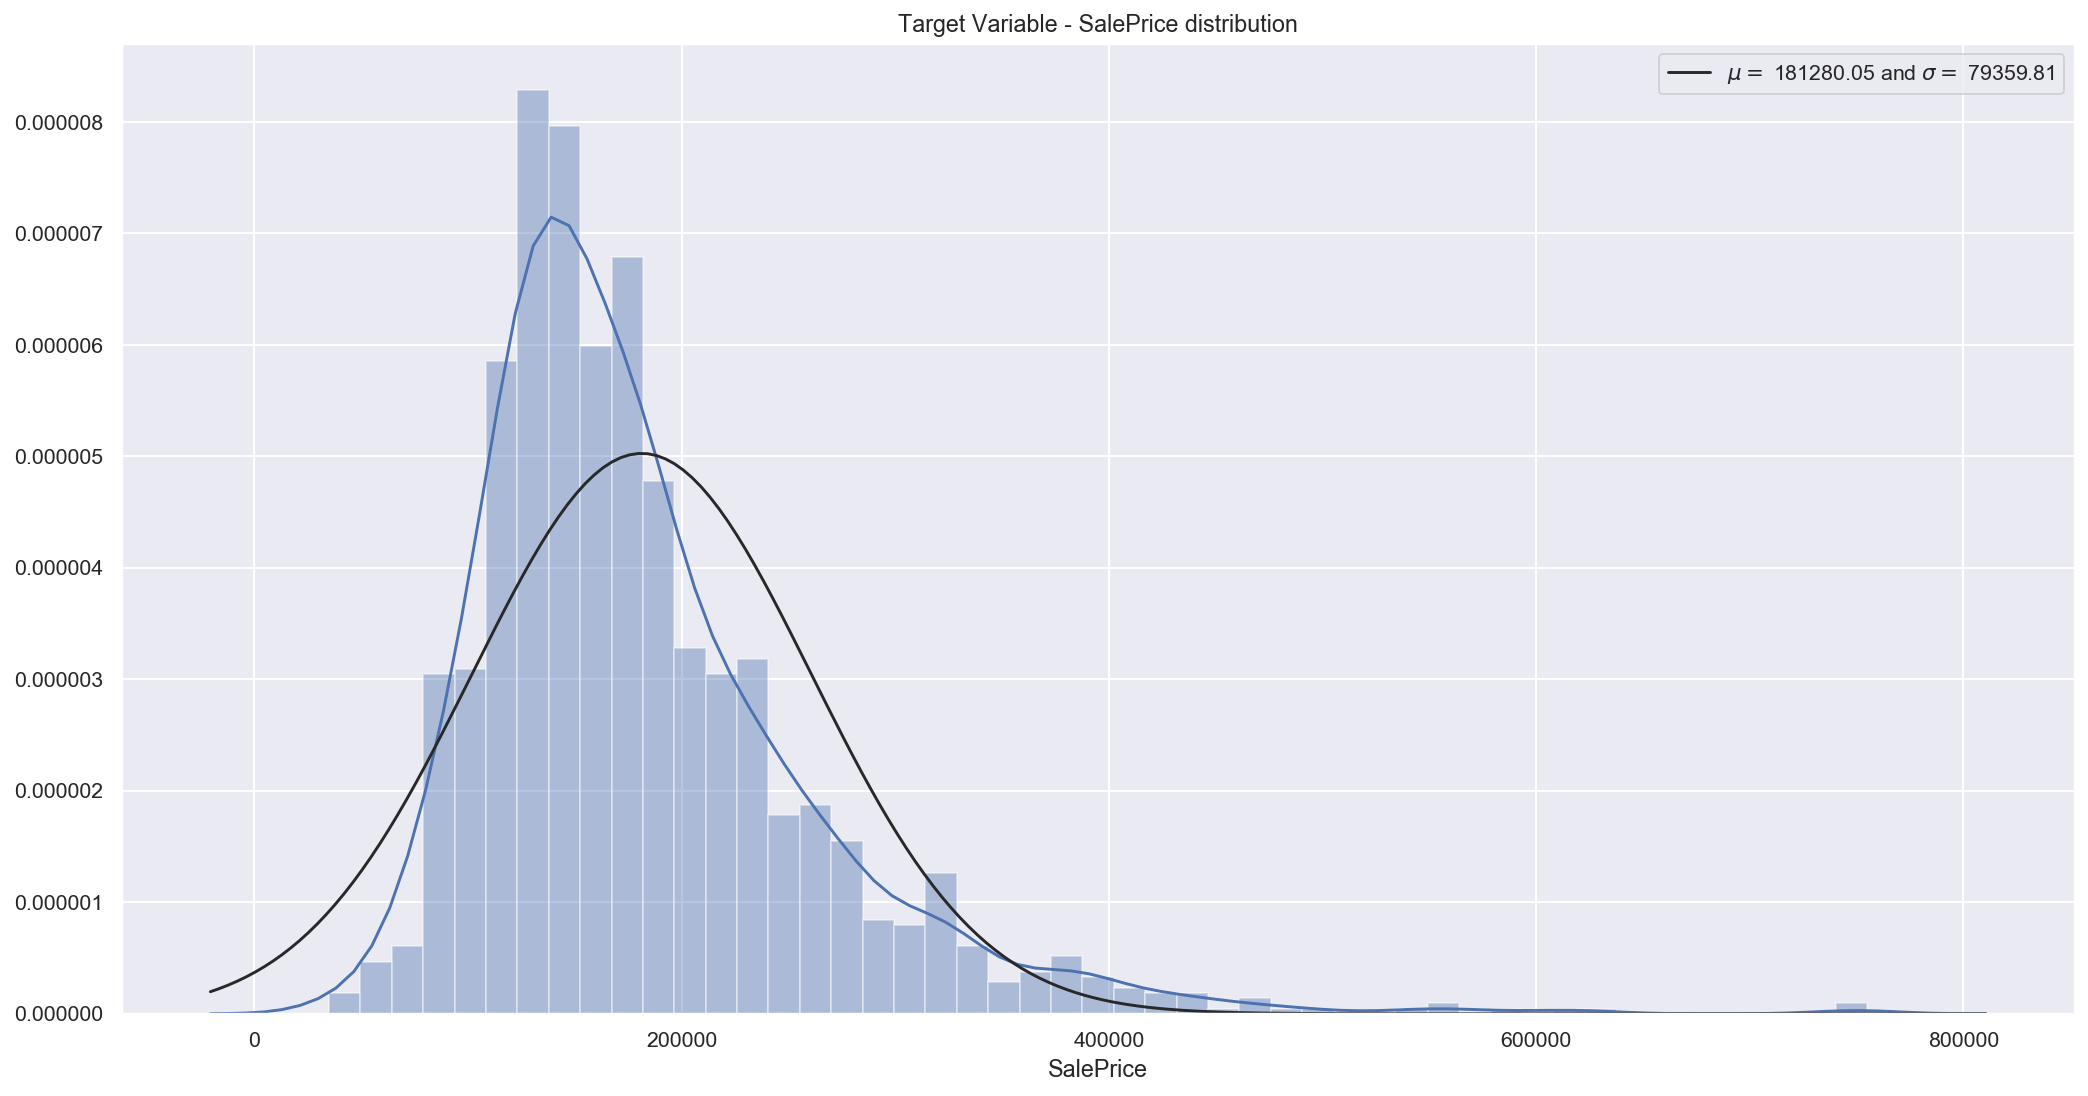

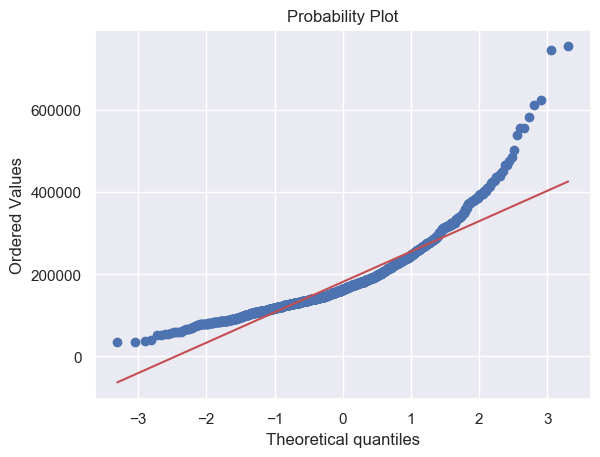

In [697]:
show_target_distribution(df_train)

As we can see in the plots above, the target variable is highly skewed. This is not good news, since linear models are working better with normally, or at least close to normally distributed data. 

Let's see if transforming those values to a logarithmic scale can help us a bit.

In [698]:
# Transforming the target variable to log (log1p is a good practice in case we have some values equal to 0 in the data set). 
# This is not the case here though, so feel free to use normal log if you will).
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

Skewness: 0.15517516869230258
Kurtosis: 0.7673281755150718


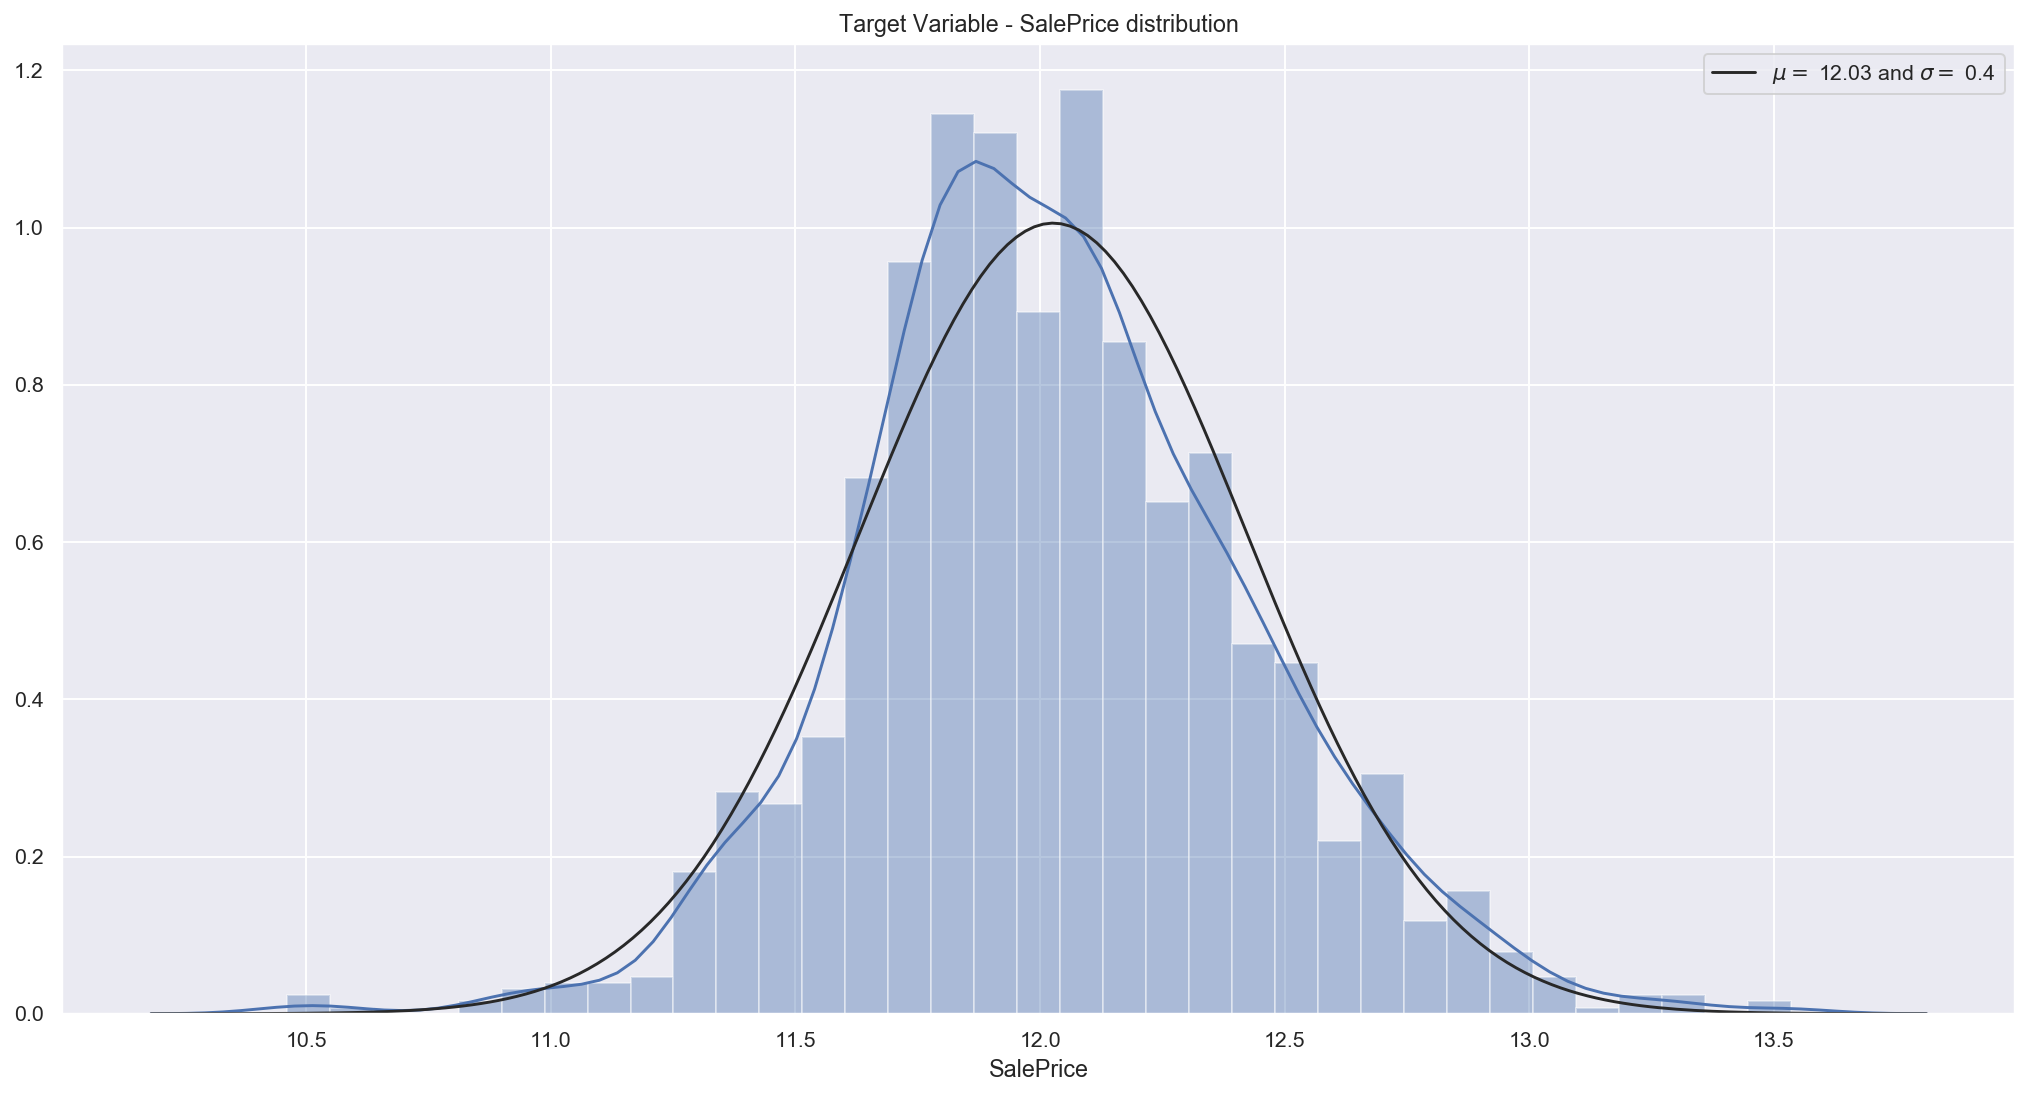

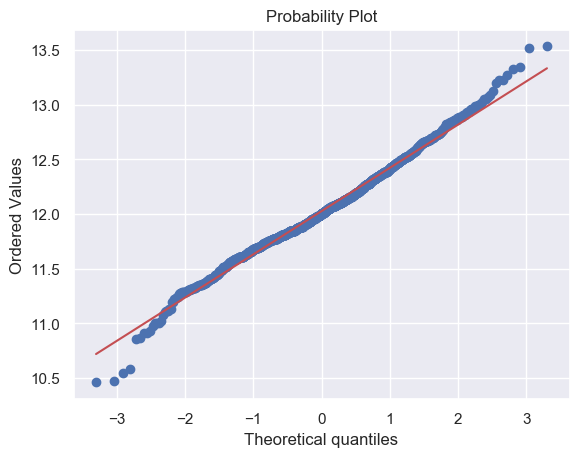

In [699]:
show_target_distribution(df_train)

Voilà, much better now.

## MISSING VALUES

In [700]:
def missing_percentage(df):
    """
    Function that helps with displaying missing values in the data set.
    """
    total = df.isnull().sum().sort_values(ascending=False)
    percent = round(total/len(df)*100, 2)
    return pd.concat([total, percent], axis=1, keys=['Total', '%'])

In [701]:
def separate_targets(df):
    """
    Function that puts target variable aside.
    """
    targets = df['SalePrice']
    return targets

def combine_datasets(train, test):
    """
    Function that merges training and test dataframes into one dataframe.
    """
    indices = len(train)
    df_combined = pd.concat([train, test], sort=True).reset_index(drop=True)
    return df_combined, indices

def recover_datasets(df, indices):
    """
    Function that recovers and splits dataframe back into train and test dataframe.
    """
    train = df.loc[:(indices - 1)].copy()
    test = df.loc[indices:].drop(['SalePrice'], axis=1).copy()
    return train, test.reset_index(drop=True)

In [702]:
train_ID = df_train['Id']
test_ID = df_test['Id']

df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

print(f'training set shape: {df_train.shape}')
print(f'test set shape: {df_test.shape}')

training set shape: (1453, 80)
test set shape: (1459, 79)


In [703]:
targets = separate_targets(df_train)

In [704]:
df_all, indices = combine_datasets(df_train, df_test)

In [705]:
df_all.shape

(2912, 80)

In [706]:
# Since we do have a lot of features, we are going to display only those containing missing values.
all_missing = missing_percentage(df_all)
all_missing[all_missing['%'] > 0]

,Total,%
PoolQC,2903,99.69
MiscFeature,2808,96.43
Alley,2715,93.23
Fence,2343,80.46
SalePrice,1459,50.10
FireplaceQu,1416,48.63
LotFrontage,486,16.69
GarageQual,158,5.43
GarageYrBlt,158,5.43
GarageFinish,158,5.43


In [707]:
def fill_NA_with_None(df, column):
    """
    Helper function that fills NA with a None string.
    """
    df[column].fillna('None', inplace=True)

def fill_NA_with_0(df, column):
    """
    Helper function that fills NA with a 0 integer.
    """
    df[column].fillna(0, inplace=True)

def fill_NA_with_mode(df, column):
    """
    Helper function that fills NA with a mode.
    """
    df[column].fillna(df[column].mode()[0], inplace=True)

### PoolQC

In [708]:
fill_NA_with_None(df_all, 'PoolQC')

### MiscFeature

In [709]:
fill_NA_with_None(df_all, 'MiscFeature')

### Alley

In [710]:
fill_NA_with_None(df_all, 'Alley')

### Fence

In [711]:
fill_NA_with_None(df_all, 'Fence')

### FireplaceQu

In [712]:
fill_NA_with_None(df_all, 'FireplaceQu')

### LotFrontage

In [713]:
df_all.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean', 'median', 'count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.851064   51.0    94
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.125714   64.0   175
Gilbert        74.207207   64.0   111
IDOTRR         62.383721   60.0    86
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.197861   73.0   374
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.701031   72.0    97
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

In this approach, I have used a very useful analysis presented here:

https://www.kaggle.com/ogakulov/lotfrontage-fill-in-missing-values-house-prices?select=housing_data_with_imputed_LotFrontage.csv

to fill the missing data for the LotFrontage variable. Instead of copying his code, I have loaded the outcome. The author has used the Support Vector Regressor (SVR) to input missing values. It appears there was a strong correlation between the LotFrontage and square root of the LotArea.

The file I have used for imputation of LotFrontage can be found under *utils/housing_data_with_imputed_LotFrontage.csv*.

In [714]:
df_frontage = pd.read_csv(r'utils/housing_data_with_imputed_LotFrontage.csv')
alex_lot_frontage = df_frontage['LotFrontage']
df_all['LotFrontage'] = alex_lot_frontage

### GarageQual

In [715]:
fill_NA_with_None(df_all, 'GarageQual')

### GarageYrBlt

In [716]:
fill_NA_with_0(df_all, 'GarageYrBlt')

### GarageFinish

In [717]:
fill_NA_with_None(df_all, 'GarageFinish')

### GarageCond

In [718]:
fill_NA_with_None(df_all, 'GarageCond')

### GarageType

In [719]:
fill_NA_with_None(df_all, 'GarageType')

### BsmtCond

In [720]:
fill_NA_with_None(df_all, 'BsmtCond')

### BsmtExposure

In [721]:
fill_NA_with_None(df_all, 'BsmtExposure')

### BsmtQual

In [722]:
fill_NA_with_None(df_all, 'BsmtQual')

### BsmtFinType2

In [723]:
fill_NA_with_None(df_all, 'BsmtFinType2')

### BsmtFinType1

In [724]:
fill_NA_with_None(df_all, 'BsmtFinType1')

### MasVnrType

In [725]:
fill_NA_with_None(df_all, 'MasVnrType')

### MasVnrArea

In [726]:
fill_NA_with_0(df_all, 'MasVnrArea')

### MSZoning

In [727]:
df_all['MSZoning'].value_counts()

RL         2261
RM          459
FV          139
RH           25
C (all)      24
Name: MSZoning, dtype: int64

In [728]:
df_all.groupby(['Neighborhood', 'MSZoning'])[['MSZoning']].agg(['count'])

MSZoning
                         count
Neighborhood MSZoning         
Blmngtn      RL             25
             RM              3
Blueste      RM             10
BrDale       RM             30
BrkSide      RL             43
             RM             64
ClearCr      RL             44
CollgCr      RL            253
             RM             14
Crawfor      RH              2
             RL             91
             RM             10
Edwards      RH              1
             RL            178
             RM             12
Gilbert      RL            165
IDOTRR       C (all)        21
             RM             68
MeadowV      RM             37
Mitchel      RL            104
             RM              9
NAmes        RH              7
             RL            435
NPkVill      RL             23
NWAmes       RL            131
NoRidge      RL             71
NridgHt      RL            165
             RM              1
OldTown      C (all)         2
             RL             39
             RM            198
SWISU        C (all)         1
             RH              9
             RL             38
Sawyer       RL            147
             RM              3
SawyerW      RH              6
             RL            119
Somerst      FV            139
             RL             43
StoneBr      RL             51
Timber       RL             72
Veenker      RL             24

In [729]:
df_all[df_all['MSZoning'].isna()]['Neighborhood']

1908     IDOTRR
2209     IDOTRR
2243     IDOTRR
2897    Mitchel
Name: Neighborhood, dtype: object

In [730]:
# Assigning mode of these two neigborhoods to variables.
ido_mode = df_all[df_all['Neighborhood'] == 'IDOTRR']['MSZoning'].mode()[0]
mitch_mode = df_all[df_all['Neighborhood'] == 'Mitchel']['MSZoning'].mode()[0]

In [731]:
df_all[df_all['MSZoning'].isna()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1908,810,0,0,None,1,1Fam,None,None,0.0,0.0,...,ConLD,0,Grvl,4,0.0,NaN,119,1910,1950,2009
2209,733,0,0,None,2,1Fam,None,None,0.0,0.0,...,WD,0,Pave,4,0.0,AllPub,0,1952,1952,2008
2243,1150,686,0,None,4,1Fam,TA,No,0.0,0.0,...,WD,0,Pave,7,686.0,AllPub,0,1900,1950,2008
2897,1600,0,0,None,3,1Fam,None,None,0.0,0.0,...,WD,0,Pave,6,0.0,AllPub,0,1951,1951,2006


In [732]:
# Filling missing MSZoning values with mode based on the neighborhood.
df_all.loc[(df_all['MSZoning'].isna()) & (df_all['Neighborhood'] == 'IDOTRR'), 'MSZoning'] = ido_mode
df_all.loc[(df_all['MSZoning'].isna()) & (df_all['Neighborhood'] == 'Mitchel'), 'MSZoning'] = mitch_mode

In [733]:
df_all[df_all['MSZoning'].isna()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold


### BsmtHalfBath

In [734]:
fill_NA_with_0(df_all, 'BsmtHalfBath')

### Utilities

In [735]:
df_all['Utilities'].value_counts()

AllPub    2909
NoSeWa       1
Name: Utilities, dtype: int64

In [736]:
# Dropping Utilities feature, due to the lack of information it provides. As we can see all of the records except one 
# are in 'AllPub' category.
df_all.drop(['Utilities'], axis=1, inplace=True)

### Functional

In [737]:
df_all['Functional'].value_counts()

Typ     2710
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

In [738]:
fill_NA_with_mode(df_all, 'Functional')

### BsmtFullBath

In [739]:
fill_NA_with_0(df_all, 'BsmtFullBath')

### Electrical

In [740]:
df_all['Electrical'].value_counts()

SBrkr    2665
FuseA     187
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [741]:
fill_NA_with_mode(df_all, 'Electrical')

### Exterior2nd

In [742]:
df_all['Exterior2nd'].value_counts()

VinylSd    1013
MetalSd     445
HdBoard     406
Wd Sdng     390
Plywood     270
CmentBd     125
Wd Shng      81
Stucco       46
BrkFace      46
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

In [743]:
fill_NA_with_mode(df_all, 'Exterior2nd')

### KitchenQual

In [744]:
df_all['KitchenQual'].value_counts()

TA    1488
Gd    1150
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

In [745]:
fill_NA_with_mode(df_all, 'KitchenQual')

### GarageCars

In [746]:
fill_NA_with_0(df_all, 'GarageCars')

### Exterior1st

In [747]:
df_all['Exterior1st'].value_counts()

VinylSd    1024
MetalSd     448
HdBoard     442
Wd Sdng     410
Plywood     221
CemntBd     125
BrkFace      86
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
Stone         2
CBlock        2
AsphShn       2
ImStucc       1
Name: Exterior1st, dtype: int64

In [748]:
fill_NA_with_mode(df_all, 'Exterior1st')

### GarageArea

In [749]:
fill_NA_with_0(df_all, 'GarageArea')

### TotalBsmtSF

In [750]:
fill_NA_with_0(df_all, 'TotalBsmtSF')

### BsmtUnfSF

In [751]:
fill_NA_with_0(df_all, 'BsmtUnfSF')

### BsmtFinSF2

In [752]:
fill_NA_with_0(df_all, 'BsmtFinSF2')

### BsmtFinSF1

In [753]:
fill_NA_with_0(df_all, 'BsmtFinSF1')

### SaleType

In [754]:
df_all['SaleType'].value_counts()

WD       2520
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [755]:
fill_NA_with_mode(df_all, 'SaleType')

In [756]:
# Double-checking if there are no missing values left.
missing_percentage(df_all)

,Total,%
SalePrice,1459,50.1
YrSold,0,0.0
Foundation,0,0.0
ExterCond,0,0.0
ExterQual,0,0.0
...,...,...
MSSubClass,0,0.0
MSZoning,0,0.0
MasVnrArea,0,0.0
MasVnrType,0,0.0


## FEATURE ENGINEERING

In [757]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2912 entries, 0 to 2911
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       2912 non-null   int64  
 1   2ndFlrSF       2912 non-null   int64  
 2   3SsnPorch      2912 non-null   int64  
 3   Alley          2912 non-null   object 
 4   BedroomAbvGr   2912 non-null   int64  
 5   BldgType       2912 non-null   object 
 6   BsmtCond       2912 non-null   object 
 7   BsmtExposure   2912 non-null   object 
 8   BsmtFinSF1     2912 non-null   float64
 9   BsmtFinSF2     2912 non-null   float64
 10  BsmtFinType1   2912 non-null   object 
 11  BsmtFinType2   2912 non-null   object 
 12  BsmtFullBath   2912 non-null   float64
 13  BsmtHalfBath   2912 non-null   float64
 14  BsmtQual       2912 non-null   object 
 15  BsmtUnfSF      2912 non-null   float64
 16  CentralAir     2912 non-null   object 
 17  Condition1     2912 non-null   object 
 18  Conditio

In [758]:
# Mapping some categorical features that are acting like a ranking to preserve the order.
mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
df_all[['ExterQual', 'ExterCond', 'BsmtQual','BsmtCond', 'HeatingQC',
        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']] = df_all[['ExterQual', 'ExterCond', 
                                                                             'BsmtQual','BsmtCond', 
                                                                             'HeatingQC','KitchenQual', 
                                                                             'FireplaceQu', 'GarageQual', 
                                                                             'GarageCond']].replace(mapping)
mapping2 = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
df_all['BsmtExposure'] = df_all['BsmtExposure'].replace(mapping2)

mapping3 = {'GLQ': 4,'ALQ': 3,'BLQ': 2,'Rec': 3,'LwQ': 2,'Unf': 1,'None': 0}
df_all[['BsmtFinType1', 'BsmtFinType2']] = df_all[['BsmtFinType1', 'BsmtFinType2']].replace(mapping3)

mapping4 = {'Y': 1, 'N': 0}
df_all['CentralAir'] = df_all['CentralAir'].replace(mapping4)

mapping5 = {'Typ': 3, 'Min1': 2.5, 'Min2': 2, 'Mod': 1.5, 'Maj1': 1, 'Maj2': 0.5, 'Sev': 0, 'Sal': 0}
df_all['Functional'] = df_all['Functional'].replace(mapping5)

In [759]:
# Converting this features into string, since they are straight up categorical values based on the data description.
df_all['MSSubClass'] = df_all['MSSubClass'].apply(str)
df_all['YrSold'] = df_all['YrSold'].apply(str)
df_all['MoSold'] = df_all['MoSold'].apply(str)

At this stage, we will create additional features that can be promising with regard to predicting the target variable.

In [760]:
# Total Area in square feet.
df_all['TotalSF'] = df_all['TotalBsmtSF'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']
# Total porch in square feet.
df_all['TotalPorchSF'] = df_all['OpenPorchSF'] + df_all['3SsnPorch'] + df_all['EnclosedPorch'] + df_all['ScreenPorch'] + df_all['WoodDeckSF']
# Features that will capture time between original feature and the time when house was actually sold.
df_all['YearsSinceBuilt'] = df_all['YrSold'].astype(int) - df_all['YearBuilt']
df_all['YearsSinceRemod'] = df_all['YrSold'].astype(int) - df_all['YearRemodAdd']
# Approximated Lot Depth
df_all['LotDepth'] = df_all['LotArea'] / df_all['LotFrontage']
# Boolean features for denoting if a certain feature is present in the house, or not.
df_all['HasPool'] = df_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['Has2ndFloor'] = df_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasGarage'] = df_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasBsmt'] = df_all['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasFireplace'] = df_all['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [761]:
# I have used mapping for some categorical features instead of LabelEncoding, however 
# I will leave the class construct here, even though it is not used in the further Pipeline!
class LabelEncoding(BaseEstimator, TransformerMixin):
    """
    Class the performs LabelEncoding on the given data set.
    """
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        encoder = LabelEncoder()
        for col in self.columns:
            X[col] = encoder.fit_transform(X[col])
        return X

In [762]:
class NormalizeSkewness(BaseEstimator, TransformerMixin):
    """
    Class the normalize the skewness by performing Boxcox transformation to each feature that is skewed beyond the 
    boundary that was passed as an argument.
    """
    def __init__(self, skewness_boundry, lambd):
        self.skewness_boundry = skewness_boundry   # skewness boundry.
        self.lambd = lambd   # lambda for boxcox transformation.
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_numeric = X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewed_features = skewness[abs(skewness) > self.skewness_boundry].index
        X[skewed_features] = boxcox1p(X[skewed_features], self.lambd)
        return X

In [763]:
class CreateDummies(BaseEstimator, TransformerMixin):
    """
    Class that performs creation of dummies.
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.get_dummies(X)
        return X

In [764]:
data_pipeline = Pipeline([
    ('NormalizeSkewness', NormalizeSkewness(0.5, 0.15)),
    ('CreateDummies', CreateDummies()),
])

In [765]:
df_all_cp = df_all.copy()

In [766]:
df_processed = data_pipeline.fit_transform(df_all_cp)

In [767]:
df_processed

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,11.692623,11.686189,0.0,3,1.540963,0.730463,11.170327,0.0,4,0.730463,...,0,0,1,0,1,0,0,1,0,0
1,12.792276,0.000000,0.0,3,1.540963,1.820334,12.062832,0.0,3,0.730463,...,0,0,1,0,1,0,1,0,0,0
2,11.892039,11.724598,0.0,3,1.540963,1.194318,10.200343,0.0,4,0.730463,...,0,0,1,0,1,0,0,1,0,0
3,12.013683,11.354094,0.0,3,1.820334,0.730463,8.274266,0.0,3,0.730463,...,0,0,1,0,1,1,0,0,0,0
4,12.510588,12.271365,0.0,4,1.540963,1.540963,10.971129,0.0,4,0.730463,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,10.496872,10.496872,0.0,3,1.540963,0.730463,0.000000,0.0,1,0.730463,...,0,0,1,0,1,1,0,0,0,0
2908,10.496872,10.496872,0.0,3,1.540963,0.730463,8.622254,0.0,3,0.730463,...,0,0,1,0,1,1,0,0,0,0
2909,12.703313,0.000000,0.0,4,1.540963,0.730463,12.703313,0.0,3,0.730463,...,0,0,1,0,1,1,0,0,0,0
2910,12.039794,0.000000,0.0,3,1.540963,1.540963,9.301176,0.0,4,0.730463,...,0,0,1,0,1,1,0,0,0,0


Lets take a look on distribution of one of the features before and after boxcox transformation.

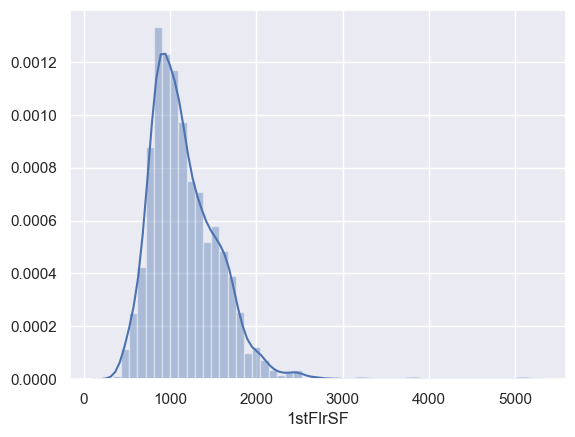

In [768]:
# Before boxcox transformation.
sns.distplot(df_all['1stFlrSF'])

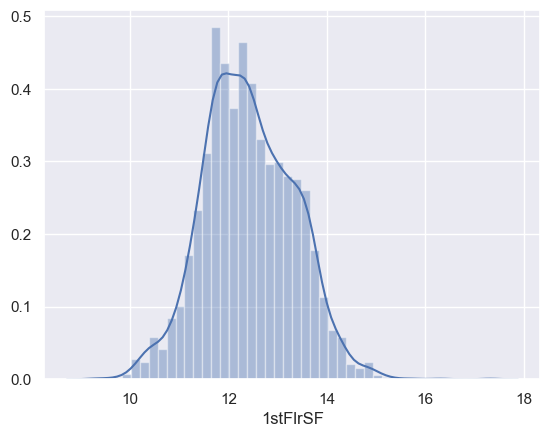

In [769]:
# After boxcox transformation.
sns.distplot(df_processed['1stFlrSF'])

In [770]:
df_train, df_test = recover_datasets(df_processed, indices)
print(f'Recovered training set shape: {df_train.shape}')
print(f'Recovered test set shape: {df_test.shape}')

Recovered training set shape: (1453, 280)
Recovered test set shape: (1459, 279)


In [771]:
X = df_train.drop(['SalePrice'], axis=1)
y = targets

One more thing that has to be done before we can move on to modeling part... 

Reducing features that are demonstrating a high homogeneity is quite a new concept to me, I have learned about it from the notebook I will reference below. It is a very useful one, and you should give it a shot.

https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing

In [772]:
def reduceFeatures(X, boundry):
    """
    Function that is reducing number of feature based on their homogeneity.
    """
    to_be_dropped = []
    for feature in X:
        value_counts = X[feature].value_counts()
        most_frequent = value_counts.iloc[0]
        if most_frequent / len(X) * 100 > boundry:
            to_be_dropped.append(feature)
    print(f'Features that display substential homogeneity: \n {to_be_dropped}')
    return to_be_dropped

In [773]:
features_to_be_dropped = reduceFeatures(X, 99.5)

Features that display substential homogeneity: 
 ['PoolArea', 'HasPool', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'Electrical_FuseP', 'Electrical_Mix', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Exterior2nd_Other', 'Exterior2nd_Stone', 'Foundation_Stone', 'Foundation_Wood', 'GarageType_2Types', 'Heating_Floor', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'LotConfig_FR3', 'MSSubClass_150', 'MSSubClass_40', 'MiscFeature_Gar2', 'MiscFeature_Othr', 'MiscFeature_TenC', 'Neighborhood_Blueste', 'PoolQC_Ex', 'PoolQC_Fa', 'PoolQC_Gd', 'PoolQC_None', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'SaleCondition_AdjLand', 'SaleType_CWD', 'Sa

In [774]:
X.drop(features_to_be_dropped, axis=1, inplace=True)
df_test.drop(features_to_be_dropped, axis=1, inplace=True)
print(f'Training set shape after reduction: {X.shape}')
print(f'Test set shape after reduction: {df_test.shape}')

Training set shape after reduction: (1453, 223)
Test set shape after reduction: (1459, 223)


# MODELING

In [775]:
n_folds = 10   # number of folds

def rmse_cv(model):
    """
    Function that measures Root Mean Square Error (RMSE) using shuffled kFold. 
    """
    kf = KFold(n_folds, shuffle=True, random_state=SEED).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y.values, scoring='neg_mean_squared_error', cv=kf))
    return rmse

In [776]:
def show_basic_score(model, model_name):
    """
    Helper function that prints out the model matrics.
    """
    print(f'{model_name} score:    {round(model.mean(), 4)} ({round(model.std(), 4)})')

In [777]:
class grid_search():
    """
    Helper function that performs GridSearch.
    """
    def __init__(self, model):
        self.model = model
        self.model_name = type(model).__name__
    
    def display_grid_results(self, X, y, param_grid):
        grid= GridSearchCV(self.model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
        grid.fit(X, y)
        print(self.model_name)
        print('====================================================================')
        print(np.sqrt(-grid.best_score_))
        print(grid.best_params_)
        print(grid.best_estimator_)
        return grid.best_params_

## Ridge Regression

In [778]:
param_grid = {
    'alpha': [11.07, 11.08, 11.09, 11.1, 11.11, 11.12, 11.13],
            }

ridge_params = grid_search(Ridge(random_state=SEED)).display_grid_results(X, y, param_grid)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Ridge
0.11133506055630181
{'alpha': 11.07}
Ridge(alpha=11.07, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='auto', tol=0.001)


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.8s finished


In [779]:
ridge = Ridge(random_state=SEED, **ridge_params)
model_name = type(ridge).__name__
ridge_pipe = make_pipeline(RobustScaler(), ridge)

In [780]:
show_basic_score(rmse_cv(ridge_pipe), model_name)

Ridge score:    0.1078 (0.0124)


## Lasso Regression

In [781]:
param_grid= {
    'alpha': [0.00049, 0.0005, 0.00051],
    'max_iter': [1e7],
}

lasso_params = grid_search(Lasso(random_state=SEED)).display_grid_results(X, y, param_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.6s finished


Lasso
0.10913213185913646
{'alpha': 0.00049, 'max_iter': 10000000.0}
Lasso(alpha=0.00049, copy_X=True, fit_intercept=True, max_iter=10000000.0,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)


In [782]:
lasso = Lasso(random_state=SEED, **lasso_params)
model_name = type(lasso).__name__
lasso_pipe = make_pipeline(RobustScaler(), lasso)

In [783]:
show_basic_score(rmse_cv(lasso_pipe), model_name)

Lasso score:    0.107 (0.0127)


## Elastic Net Regression

In [784]:
param_grid = {
    'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007],
    'l1_ratio': [0.8, 0.85, 0.9, 0.95, 0.99, 1],
    'max_iter': [1e7],
}

Enet_params = grid_search(ElasticNet(random_state=SEED)).display_grid_results(X, y, param_grid)

Enet = ElasticNet(random_state=SEED, **Enet_params)
model_name = type(Enet).__name__
Enet_pipe = make_pipeline(RobustScaler(), Enet)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   52.7s finished


ElasticNet
0.10901980128705696
{'alpha': 0.0004, 'l1_ratio': 0.9, 'max_iter': 10000000.0}
ElasticNet(alpha=0.0004, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=10000000.0, normalize=False, positive=False,
           precompute=False, random_state=42, selection='cyclic', tol=0.0001,
           warm_start=False)


In [785]:
show_basic_score(rmse_cv(Enet_pipe), model_name)

ElasticNet score:    0.107 (0.0125)


It is worth noticing that in this case, Elastic Net is acting almost exactly like Lasso Regression since we have found out that the best l1 ratio is 0.9.

## Kernel Ridge Regression

In [786]:
param_grid = {
    'alpha': [0.7, 0.5, 0.1, 0.01],
    'kernel':['polynomial'],
    'degree':[2, 3],
    'coef0':[2.5, 2.7, 2.9, 3.1]
}

krr_params = grid_search(KernelRidge()).display_grid_results(X, y, param_grid)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s


KernelRidge
0.14061072161450613
{'alpha': 0.7, 'coef0': 2.5, 'degree': 2, 'kernel': 'polynomial'}
KernelRidge(alpha=0.7, coef0=2.5, degree=2, gamma=None, kernel='polynomial',
            kernel_params=None)


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    9.5s finished


In [787]:
krr = KernelRidge(**krr_params)
model_name = type(krr).__name__
krr_pipe = make_pipeline(RobustScaler(), krr)

In [788]:
show_basic_score(rmse_cv(krr_pipe), model_name)

KernelRidge score:    0.1123 (0.0112)


## Gradient Boosting Regression

In [789]:
param_grid = {
    "n_estimators": [2000, 3000, 4000],
    "learning_rate": [0.01, 0.05, 0.1, 0.15],
    "max_depth": [2, 3, 4],
    "min_samples_leaf": [5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "loss": ['lad', 'huber']
}

#Gboost_params = grid_search(GradientBoostingRegressor(random_state=SEED)).display_grid_results(X, y, param_grid)

I have used GridSearch to find optimal parameters first and kept re-using them later since the whole grid search for Gradient Boosting Regression takes a lot of time!

In [790]:
manual_gboost_params =  {
    'learning_rate': 0.05,  
    'loss': 'huber', 
    'max_depth': 2, 
    'min_samples_leaf': 5, 
    'min_samples_split': 2, 
    'n_estimators': 3000
}

In [791]:
Gboost = GradientBoostingRegressor(random_state=SEED, **manual_gboost_params)
model_name = type(Gboost).__name__

In [792]:
show_basic_score(rmse_cv(Gboost), model_name)

GradientBoostingRegressor score:    0.1112 (0.0149)


## XGBoost

I have used Bayesian Optimization to find the best hyperparameters for the XGBoost since regular GridSaerch or RandomSearch is just not time efficient. You can find a quick notebook with how I have set up the Bayesian Optimization in the utils folder for this project.

PS I highly recommend giving the article below a read. It helped me enormously with understanding the whole process.

http://krasserm.github.io/2018/03/21/bayesian-optimization/

In [793]:
bayesopt_xgboost_params = {
    'colsample_bytree': 0.4567076462540898, 
    'gamma': 0.012019869058477422, 
    'learning_rate': 0.014920471289453069, 
    'max_depth': 3, 
    'min_child_weight': 5, 
    'n_estimators': 2900, 
    'reg_alpha': 0.06782148660350684, 
    'reg_lambda': 0.32567387074997145, 
    'subsample': 0.6583670239609184,
    'n_jobs': -1
}


# Credit for hyperparameter tunning for this algorithm goes to the author of this notebook:
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
# my attempts including bayesian opt were yielding worse results than his parameters.
sergine_params = {
    'colsample_bytree': 0.4603, 
    'gamma': 0.0468, 
    'learning_rate': 0.05, 
    'max_depth': 3, 
    'min_child_weight': 1.7817, 
    'n_estimators': 2200, 
    'reg_alpha': 0.4640, 
    'reg_lambda': 0.8571, 
    'subsample': 0.5213,
    'n_jobs': -1
}

In [794]:
xgboost = XGBRegressor(random_state=SEED, **sergine_params)
model_name = type(xgboost).__name__

In [795]:
show_basic_score(rmse_cv(xgboost), model_name)

XGBRegressor score:    0.1104 (0.0123)


## LightGBM

I have used Bayesian Optimization to find the best hyperparameters for the LightGBM as well. Even though GridSearch it not as time-consuming as it is in the case of XGboost, I have decided to use Bayesian Optimization. You can find the code which I had run to optimize hyperparameters in the utils folder for this project.

In [796]:
bayesopt_lgbm_params = {
     'bagging_fraction': 0.8137935684744166,
     'bagging_freq': 1,
     'feature_fraction': 0.1203250663101442,
     'learning_rate': 0.012656960356800398,
     'max_bin': 115,
     'max_depth': 3,
     'min_child_weight': 8,
     'n_estimators': 3700,
     'num_leaves': 11,
     'reg_alpha': 0.06433149789068834,
     'reg_lambda': 0.5329368640791979
}


m_manual_params = {
     'bagging_fraction': 0.75,
     'bagging_freq': 5,
     'feature_fraction': 0.2,
     'learning_rate': 0.01,
     'max_bin': 120,
     'n_estimators': 9000,
     'num_leaves': 4,
}

Even though I have used BayesianOptimization to find the best parameters I was not satisfied with the algorithm since it was massively overfitting and I decided to play with them manually to find something that yields better final results.

In [797]:
lgbm = lgb.LGBMRegressor(random_state=SEED, **m_manual_params)

In [798]:
model_name = type(lgbm).__name__

In [799]:
show_basic_score(rmse_cv(lgbm), model_name)

LGBMRegressor score:    0.1095 (0.0134)


## STACKING MODELS

In [800]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    """
    Simple Class that averages predictions of models.
    """
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [801]:
avg_models = AveragingModels(models=(ridge_pipe, lasso_pipe, krr_pipe, Enet_pipe))
model_name = 'Average of four models: Ridge, Lasso, Krr, Enet'

In [802]:
show_basic_score(rmse_cv(avg_models), model_name)

Average of four models: Ridge, Lasso, Krr, Enet score:    0.1062 (0.012)


In [803]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    """
    Class that performs stacking with inclusion of the meta model.
    Credits for the idea goes to the owner of the notebook referenced below:
    https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
    """
    def __init__(self, base_models, meta_model, seed, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.seed = seed
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.seed)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [804]:
stacked_avg_models = StackingAveragedModels(base_models=[ridge_pipe, krr_pipe, Enet_pipe, xgboost], meta_model=lasso_pipe, seed=SEED)
model_name = 'Stacked: Ridge, Krr, Enet, XGboost'

In [805]:
show_basic_score(rmse_cv(stacked_avg_models), model_name)

Stacked: Ridge, Krr, Enet, XGboost score:    0.105 (0.0123)


In [806]:
def rmse(y, y_pred):
    """
    Function that calculates root mean square error.
    """
    return np.sqrt(mean_squared_error(y, y_pred))

Fitting final models to the whole data set and displaying the score.

In [807]:
stacked_avg_models.fit(X.values, y.values)
stacked_train_pred = stacked_avg_models.predict(X.values)
stacked_pred = np.expm1(stacked_avg_models.predict(df_test.values))
rmse(y, stacked_train_pred)

0.08613673857803339

In [808]:
xgboost.fit(X.values, y.values)
xgboost_train_pred = xgboost.predict(X.values)
xgboost_pred = np.expm1(xgboost.predict(df_test.values))
rmse(y, xgboost_train_pred)

0.07647441074344083

In [809]:
lgbm.fit(X.values, y.values)
lgbm_train_pred = lgbm.predict(X.values)
lgbm_pred = np.expm1(lgbm.predict(df_test.values))
rmse(y, lgbm_train_pred)

0.05852665623153081

In [810]:
Enet_pipe.fit(X.values, y.values)
Enet_train_pred = Enet_pipe.predict(X.values)
Enet_pred = np.expm1(Enet_pipe.predict(df_test.values))
rmse(y, Enet_train_pred)

0.096654501394362

I have manually inspected different permutations of these algorithms with different weights assigned and I came up with the final approach that I eventually submitted. I have mixed stacked predictions with Lgbm in 70% to 30% proportions. 

In [811]:
ensemble_pred = stacked_pred * 0.7 + lgbm_pred * 0.3

In [812]:
def generate_sub_file(description, predictions, test_ID=test_ID, user='Bogusz'):
    """
    Helper function that creates submission files with a timestamp for convenience.
    """
    today = datetime.datetime.now()
    fn = f"{user}_{description}_{today.year}-{today.month}-{today.day}_{today.hour}-{today.minute}"
    df = pd.DataFrame()
    df['Id'] = test_ID
    df['SalePrice'] = predictions
    df.to_csv(f"{fn}.csv", index=False)
    print(f'Files saved successfuly as {fn}')

In [813]:
generate_sub_file('70_30_STACKED_LGBM_FIN_SUB', ensemble_pred)

Files saved successfuly as Bogusz_70_30_STACKED_LGBM_FIN_SUB_2020-9-17_8-55
